# Project LatentArt: LatentArt Submission
## Level: ADVANCED

This notebook documents the implementation and experimentation for the Image Generation Submission.

### Environment Initialization

In [10]:
import os
import sys

print('🚀 Initializing Environment...\n')

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    import shutil
    REPO_NAME = 'LatentArt'

    try:
        token = userdata.get('GH_TOKEN')
        username = 'urobin84'
        repo_url = f'https://{token}@github.com/{username}/{REPO_NAME}.git'

        os.chdir('/content')
        if os.path.exists(REPO_NAME): shutil.rmtree(REPO_NAME)
        !git clone {repo_url}

        root_path = f'/content/{REPO_NAME}'
        if root_path not in sys.path: sys.path.insert(0, root_path)
        os.chdir(root_path)
        !pip install -r requirements.txt
        print('\n✅ Colab Setup Complete!')
    except Exception as e:
        print(f'❌ Colab Setup Failed: {e}')
else:
    # LOCAL JUPYTER LOGIC
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        root_path = os.path.abspath(os.path.join(current_dir, '..'))
    else:
        root_path = current_dir

    if root_path not in sys.path: sys.path.insert(0, root_path)
    print(f'🏠 Running locally. Root detected: {root_path}')
    print('✅ Local environment search path updated.')

🚀 Initializing Environment...

Cloning into 'LatentArt'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 147 (delta 63), reused 108 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 747.56 KiB | 3.08 MiB/s, done.
Resolving deltas: 100% (63/63), done.

✅ Colab Setup Complete!


### Load Libraries and Utilities

In [11]:
import torch
import gc
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in cast")

from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, EulerAncestralDiscreteScheduler
from PIL import Image
import matplotlib.pyplot as plt

# Gunakan utilitas bawaan, jika ini berjalan di repositori GitHub kita
try:
    from src.utils import get_device, clear_memory
    device = get_device()
    print(f'✅ Kernel Ready. Device detected: {device}')
except ImportError as e:
    print(f'⚠️ Package failed loading: {e}')
    device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

def load_scheduler(pipeline, scheduler_name='Euler A'):
    if scheduler_name == 'Euler A':
        pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)
    print(f'Scheduler set to: {scheduler_name}')

negative_prompt = 'photorealistic, realistic, photograph, 3d render, messy, blurry, low quality, bad art, ugly, sketch, grainy, unfinished, chromatic aberration'

✅ Kernel Ready. Device detected: cuda


### ⬇️ Download / Load Pipeline & Save Format to GitHub Folder

In [12]:
model_id = "runwayml/stable-diffusion-v1-5"
model_path = os.path.join(root_path, "LatentArt-Model")

# Jika model pernah didownload ke folder GitHub, muat dari repositori lokal!
# Jika tidak, download dari cloud HuggingFace kemudian simpan.
if os.path.exists(model_path):
    print(f"📦 Memuat (Load) Model secara lokal dari folder Github: {model_path}!")
    pipe_t2i = StableDiffusionPipeline.from_pretrained(
        model_path,
        torch_dtype=torch.float16 if device != "cpu" else torch.float32,
        safety_checker=None,
        requires_safety_checker=False
    )
else:
    print(f"☁️ Mendownload Model dari HuggingFace (Pastikan koneksi internet aktif)...")
    pipe_t2i = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if device != "cpu" else torch.float32,
        safety_checker=None,
        requires_safety_checker=False
    )
    print(f"🔧 Menyimpan model ke direktori repositori Github ({model_path}) agar bisa ditarik tanpa download ulang nantinya...")
    try:
        pipe_t2i.save_pretrained(model_path)
        print(f"💾 Model berhasil di-save!")
    except Exception as e:
        print(f"❌ Gagal menyimpan model: {e}")

# Memory optimizations untuk Apple Silicon M1/M2
if device == "mps":
    pipe_t2i.enable_attention_slicing()
    pipe_t2i.enable_vae_slicing()
    pipe_t2i.enable_vae_tiling()
    pipe_t2i.enable_model_cpu_offload()
elif device == "cuda":
    pipe_t2i = pipe_t2i.to("cuda")
    try:
        pipe_t2i.enable_xformers_memory_efficient_attention()
    except Exception:
        pipe_t2i.enable_attention_slicing() # Fallback jika xformers tidak ada

load_scheduler(pipe_t2i, "Euler A")

☁️ Mendownload Model dari HuggingFace (Pastikan koneksi internet aktif)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


🔧 Menyimpan model ke direktori repositori Github (/content/LatentArt/LatentArt-Model) agar bisa ditarik tanpa download ulang nantinya...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

💾 Model berhasil di-save!
Scheduler set to: Euler A


### Kriteria 1: Base Text-to-Image Generation (Menggunakan Local Model)

  0%|          | 0/30 [00:00<?, ?it/s]

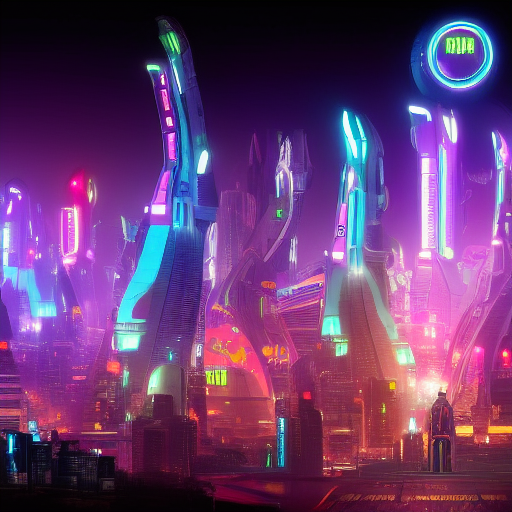

In [13]:
prompt = "A futuristic city in the style of cyberpunk, vivid neon lights, high detail, trending on artstation"
seed = 222
generator = torch.Generator(device=device).manual_seed(seed)

image = pipe_t2i(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]

output_dir = os.path.join(root_path, "outputs")
os.makedirs(output_dir, exist_ok=True)
image.save(os.path.join(output_dir, "basic_t2i.png"))
image

### Kriteria 2: Image-To-Image Refinement

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/37 [00:00<?, ?it/s]

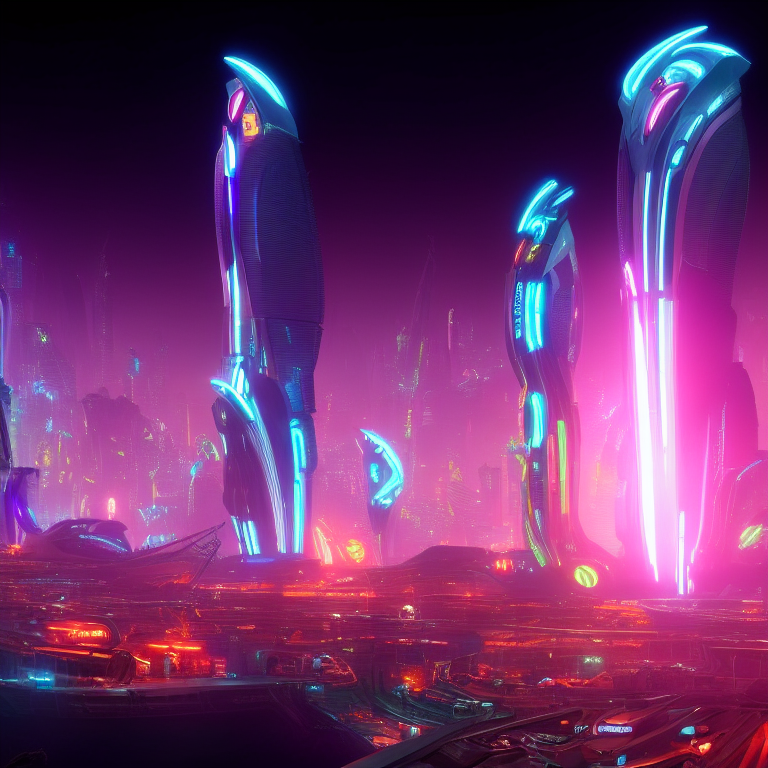

In [14]:
# Meminjam struktur T2I untuk Refiner (Image-to-Image) tanpa mendownload/memuat RAM dua kali
pipe_img2img = StableDiffusionImg2ImgPipeline(**pipe_t2i.components)

# Memory Protection Sebelum Refinement!
if device == "cuda":
    torch.cuda.empty_cache()
elif device == "mps":
    torch.mps.empty_cache()
gc.collect()

refined_image = pipe_img2img(
    prompt=prompt + ", masterpiece, 8k resolution, ultra detailed",
    negative_prompt=negative_prompt,
    image=image.resize((768, 768)), # Upscaling Base Image to Refiner Dimension
    strength=0.75,
    num_inference_steps=50,
    guidance_scale=8.0,
    generator=torch.Generator(device=device).manual_seed(111)
).images[0]

refined_image.save(os.path.join(output_dir, "advanced_refined.png"))
refined_image

### 📦 Export Model to Local Machine
Jika Anda ingin mengunduh model seberat 4GB ini ke komputer pribadi Anda dari Colab, jalankan kode di bawah ini untuk mengompresnya menjadi ZIP dan mengunduhnya.

In [ ]:
if IN_COLAB:
    import shutil
    from google.colab import files
    
    print("🗜️ Sedang mengompres model menjadi LatentArt-Model.zip... (Mohon tunggu, ini butuh beberapa menit)")
    shutil.make_archive("LatentArt-Model", "zip", "LatentArt-Model")
    
    print("📥 Memulai proses download ke browser Anda...")
    files.download("LatentArt-Model.zip")
else:
    print("🏠 Anda menjalankan ini secara lokal, model sudah ada di folder: ", os.path.join(os.getcwd(), "LatentArt-Model"))